In [1]:
#!pip install torchvision

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms as T
from torch.utils.data import Subset
import random

import synbols
from synbols.fonts import LANGUAGE_MAP
from synbols.data_io import pack_dataset
from synbols import generate
from synbols import drawing
from synbols.drawing import Camouflage, NoPattern, SolidColor, MultiGradient, ImagePattern
from synbols.fonts import LANGUAGE_MAP
from synbols.generate import (
    dataset_generator,
    basic_attribute_sampler,
    flatten_mask,
    flatten_mask_except_first,
    add_occlusion,
    rand_seed,
)
from synbols.visualization import plot_dataset
from pprint import pprint


%matplotlib inline

def show_ds(attr_sampler, verbose=False, show_mask=False):
    """Generate and show a Synbols dataset from an attribute sampler."""
    x, mask, y = pack_dataset(generate.dataset_generator(attr_sampler, 100, generate.flatten_mask))
    if verbose:
        print("Example of a label")
        pprint(y[0])

    plt.figure('dataset', figsize=[5, 5])
    plot_dataset(x, y,h_axis=None,v_axis=None, n_row=10, n_col=10)

    plt.show()
    if show_mask:
        plt.figure('dataset', figsize=[5, 5])
        plot_dataset(mask, y,h_axis=None,v_axis=None, n_row=10, n_col=10)

        plt.show()

# params

In [2]:
N_CLASSES = 200
N_TRAIN = 100000
N_VAL = 10000
N_TEST = 10000

N_TASKS = 10

# dset specs

100%|██████████| 100/100 [00:00<00:00, 183.79it/s]


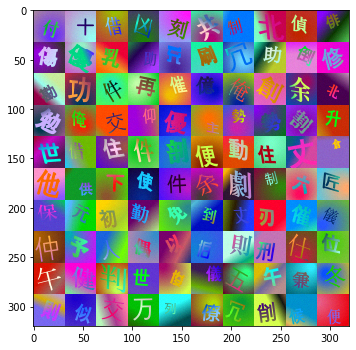

In [3]:
bg = drawing.MultiGradient(alpha=0.9, n_gradients=1, types=('linear', 'radial'))
alphabet = LANGUAGE_MAP["japanese"].get_alphabet(support_bold=True)
chars = alphabet.symbols[:N_CLASSES]
fonts = alphabet.fonts
attr_sampler = basic_attribute_sampler(inverse_color=False, background = bg, char=lambda rng: rng.choice(chars), font=lambda rng: rng.choice(fonts))
show_ds(attr_sampler, verbose=False)

# create numpy arrays

In [4]:
# generate data
x, s, y = pack_dataset(generate.dataset_generator(attr_sampler, N_TRAIN+N_TEST+N_VAL, generate.flatten_mask))

100%|██████████| 120000/120000 [04:06<00:00, 487.65it/s]


In [5]:
# split train test val
x_train, segmentation_train, y_train = x[:N_TRAIN], s[:N_TRAIN] ,y[:N_TRAIN]
x_test, segmentation_test, y_test = x[N_TRAIN:N_TRAIN+N_TEST], s[N_TRAIN:N_TRAIN+N_TEST] ,y[N_TRAIN:N_TRAIN+N_TEST]
x_val, segmentation_val, y_val = x[N_TRAIN+N_TEST:], s[N_TRAIN+N_TEST:] ,y[N_TRAIN+N_TEST:]

In [6]:
x_train.shape, x_test.shape, x_val.shape

((100000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
y_train[0]

{'resolution': (32, 32),
 'pixel_noise_scale': 0.01,
 'seed': 2990707234,
 'background': {'style': 'MultiGradient', 'seed': None},
 'alphabet': 'english',
 'char': '了',
 'font': 'SeoulNamsan CM',
 'is_bold': 'True',
 'is_slant': 'False',
 'scale': 0.5368901249634197,
 'translation': (-0.8565844554849888, -0.7903197675331551),
 'rotation': 0.7399809270998429,
 'foreground': {'style': 'Gradient', 'seed': 4170507705},
 'symbols': [{'alphabet': 'english',
   'char': '了',
   'font': 'SeoulNamsan CM',
   'is_bold': 'True',
   'is_slant': 'False',
   'scale': 0.5368901249634197,
   'translation': (-0.8565844554849888, -0.7903197675331551),
   'rotation': 0.7399809270998429,
   'foreground': {'style': 'Gradient', 'seed': 4170507705}}],
 'overlap_score': 0.0}

# GET STATISTICS

In [8]:
def get_stats(x):
    tmp = x / 255
    mu = tmp[:,:,:,0].mean(), tmp[:,:,:,1].mean(), tmp[:,:,:,2].mean()
    std = tmp[:,:,:,0].std(), tmp[:,:,:,1].std(), tmp[:,:,:,2].std()
    return mu, std

In [9]:
print('Train: ', get_stats(x_train))
print('Test: ', get_stats(x_test))

Train:  ((0.4792642212009804, 0.4790768438265941, 0.47828154484527813), (0.2841457880023103, 0.2845630535135729, 0.2840738323301523))
Test:  ((0.47531651348039183, 0.48039774471507335, 0.47890882238051447), (0.284243728119652, 0.2828713225159061, 0.285577505094918))


# SAVE DATA

In [10]:
with open('train.npz', 'wb') as f:
    np.savez(f, x_train=x_train, segmentation_train=segmentation_train, y_train=y_train, stats=get_stats(x_train))

In [11]:
with open('test.npz', 'wb') as f:
    np.savez(f, x_test=x_test, segmentation_test=segmentation_test, y_test=y_test, stats=get_stats(x_test))

In [12]:
with open('val.npz', 'wb') as f:
    np.savez(f, x_val=x_val, segmentation_val=segmentation_val, y_val=y_val, stats=get_stats(x_val))

# SPLIT TO TASK (DEBUG)

In [19]:
def get_indices(y, task):
    return [i for i in range(y.shape[0]) if y[i] in task]


def prepare_synbols(x, y, tasks):
    # convert char labels to int
    labels_data = np.zeros(x.shape[0]).astype(np.int16)
    y_char = [yi['char'] for yi in y]
    all_chars = sorted(list(set(y_char)))
    for i in range(x.shape[0]):
        labels_data[i] = all_chars.index(y_char[i])

    # create task data
    task_data = np.zeros(x.shape[0]).astype(np.int16)
    for tid, task in enumerate(tasks):
        task_indices = get_indices(labels_data, task)

        task_data[task_indices] = tid

    return x, labels_data, task_data

In [138]:
# create tasks and shuffle
tasks = [x for x in range(0, N_CLASSES)]
random.shuffle(tasks)
tasks = np.array_split(tasks, N_TASKS)

x, y, t = prepare_synbols(x_train, y_train, tasks)
print('tasks split: ', tasks)

tasks split:  [array([17, 12,  6,  3]), array([16,  5,  1,  7]), array([13,  9, 19,  4]), array([11,  8,  2, 18]), array([10, 14,  0, 15])]


# sanity check (DEBUG)

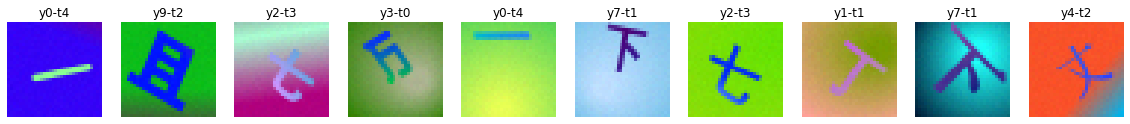

In [152]:
num_examples = 10
fig, axs = plt.subplots(nrows=1, ncols=num_examples, figsize=(20,14))
for ax, x_i, y_i, t_i in zip(axs.flatten(), x[:num_examples], y[:num_examples], t[:num_examples]):
    ax.imshow(x_i)
    ax.set_title(f"y{y_i}-t{t_i}")
    ax.axis('off')

# SURPLUS: pytorch conversion

In [6]:

# We define our Pytorch Dataset
class SynbolsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform):
        self.x, self.y, self.transform = x,y,transform
        self.y = [yi['char'] for yi in self.y]
        self._all_chars = sorted(list(set(self.y)))
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x,y = self.x[idx], self.y[idx]
        return self.transform(x), self._all_chars.index(y)
    
# Create our Synbols datasets
TRANS_TRAIN = T.Compose([T.ToPILImage(), T.RandomHorizontalFlip(), T.ToTensor()])
TRANS_TEST = T.Compose([T.ToPILImage(), T.ToTensor()])

train_ds = SynbolsDataset(x_train, y_train, transform=TRANS_TRAIN)
val_ds = SynbolsDataset(x_val, y_val, transform=TRANS_TEST)
test_ds = SynbolsDataset(x_test, y_test, transform=TRANS_TEST)